In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import pywt
import os
import cv2

2024-04-18 13:27:29.475490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 13:27:29.475563: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 13:27:29.476689: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 13:27:29.578649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 13:27:30.620068: W tensorflow/compiler/

In [2]:
def func(path_to_image):
    # Select a sample image
    sample_image = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)

    # Apply DWT
    coeffs = pywt.dwt2(sample_image, 'haar')

    # Reconstruct image using IDWT
    reconstructed_image = pywt.idwt2(coeffs, 'haar')

    # Plotting
    plt.figure(figsize=(20, 10))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # DWT Coefficients
    plt.subplot(1, 3, 2)
    cA, (cH, cV, cD) = coeffs
    plt.imshow(np.concatenate((np.concatenate((cA, cH), axis=1), np.concatenate((cV, cD), axis=1)), axis=0), cmap='gray')
    plt.title('DWT Coefficients')
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_image.astype('uint8'), cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.show()

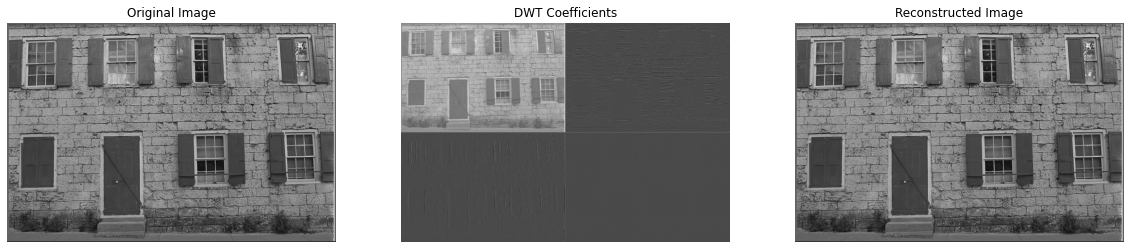

In [3]:
path_to_image = 'kodak/kodim01.png'
func(path_to_image)

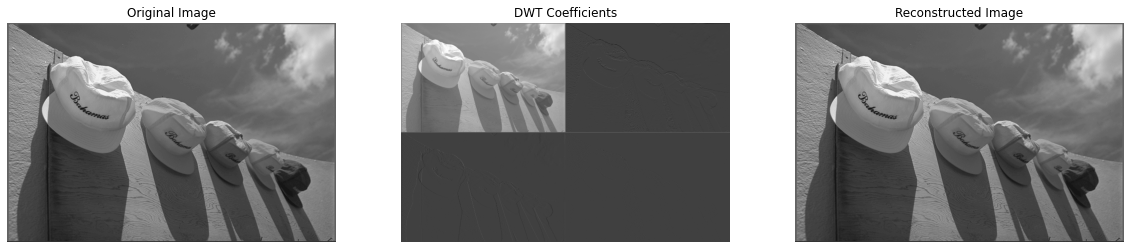

In [4]:
path_to_image = 'kodak/kodim03.png'
func(path_to_image)

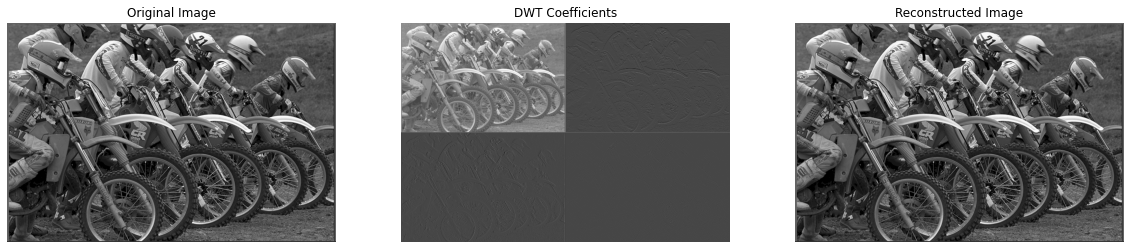

In [5]:
path_to_image = 'kodak/kodim05.png'
func(path_to_image)

reference : https://pywavelets.readthedocs.io/en/latest/

Points discussed in meeting:

1. see the effect of change in number of MSRB blocks and also internal kernal sizes in MSRB blocks on image compression.

2. a. take dwt on each Image and we will get 4 components named (LL,LH, HL,HH).
   (L : LOW PASS FILTER) (H : HIGH PASS FILTER).

   b. for each component apply encoder and decoder network model(given in paper)  and do reconstruction using idwt from outputs of 4 components for each image.

   c. As LL component is having high energy compared to others see that more depth in model for this compared to others components will improve accuracy and also reduce model complexity.


3. you can also look into in aliasing phenomenon.

4. As final goal is to run on hardware (rpi, fpga) you can convert the pytorch into tensorflow and run the code.



In [6]:
def dwt_and_save(image_folder, output_folder):
    # Create output folders if they don't exist
    for component in ['LL', 'LH', 'HL', 'HH']:
        folder_path = os.path.join(output_folder, component)
        os.makedirs(folder_path, exist_ok=True)

    # Get list of image files in the input folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    for image_file in image_files:
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Perform DWT
        LL, (LH, HL, HH) = pywt.dwt2(image, 'haar')

        # Save components into separate folders
        components = {'LL': LL, 'LH': LH, 'HL': HL, 'HH': HH}
        for component, img in components.items():
            output_path = os.path.join(output_folder, component, image_file)
            cv2.imwrite(output_path, img)


In [7]:
input_folder = "kodak/"
output_folder ="output/"

dwt_and_save(input_folder, output_folder)

In [21]:
def plot_images_from_folders(folders, n):
    fig, axes = plt.subplots(1, 4, figsize=(15, 20))
    for ax, folder in zip(axes, folders):
        image_files = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        if image_files:
            image_path = os.path.join(folder, image_files[n])
            image = plt.imread(image_path)
            ax.imshow(image, cmap='gray')
            ax.set_title(os.path.basename(folder))
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [22]:
LL_folder = "output/LL/"
LH_folder = "output/LH/"
HL_folder = "output/HL/"
HH_folder = "output/HH/"

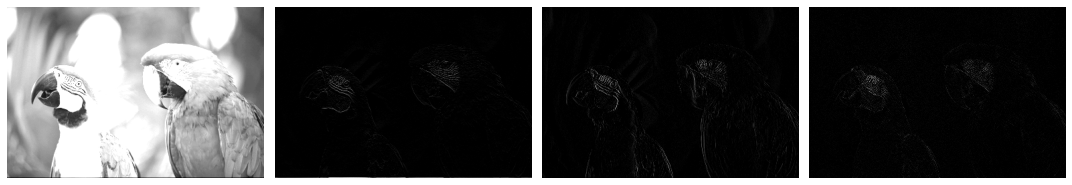

In [23]:
plot_images_from_folders([LL_folder, LH_folder, HL_folder, HH_folder], 0)

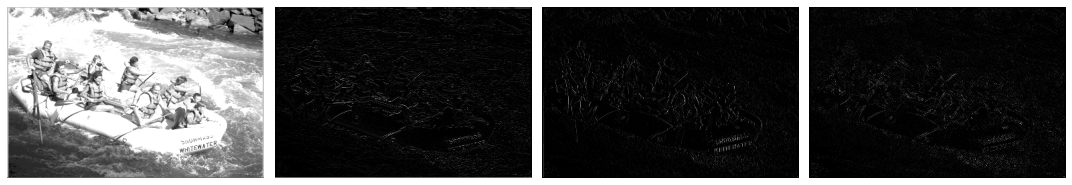

In [24]:
plot_images_from_folders([LL_folder, LH_folder, HL_folder, HH_folder], 1)

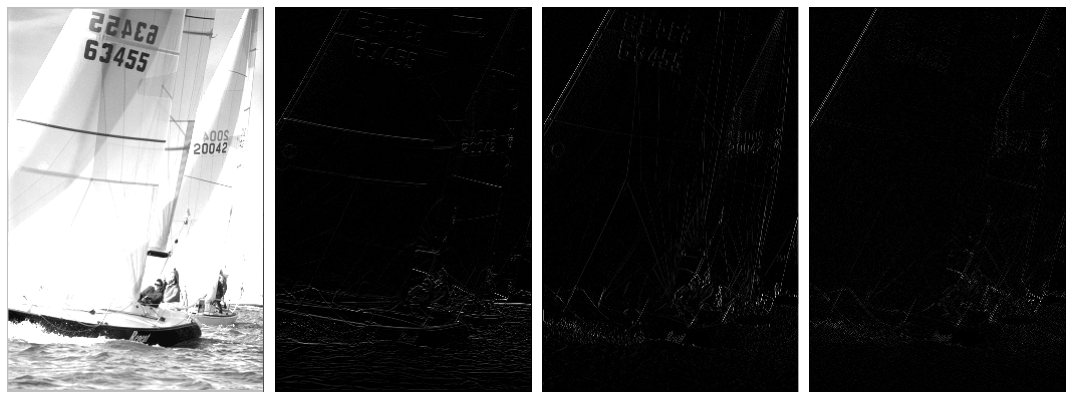

In [25]:
plot_images_from_folders([LL_folder, LH_folder, HL_folder, HH_folder], 2)

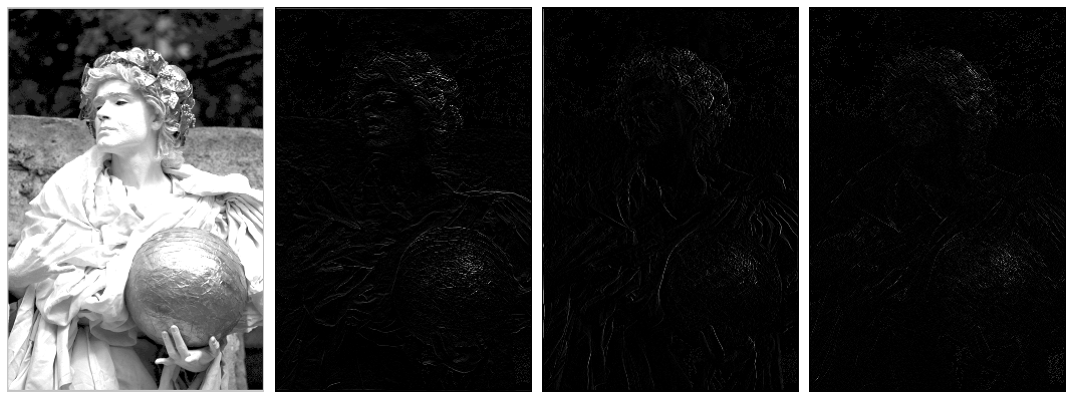

In [26]:
plot_images_from_folders([LL_folder, LH_folder, HL_folder, HH_folder], 3)

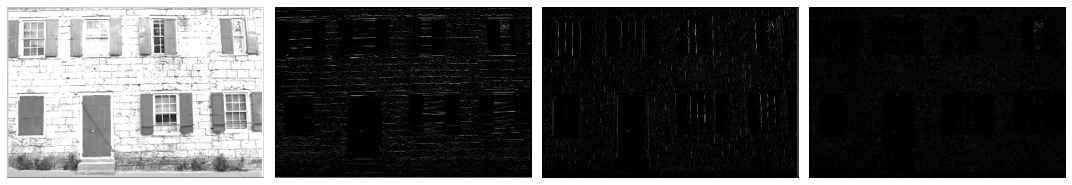

In [27]:
plot_images_from_folders([LL_folder, LH_folder, HL_folder, HH_folder], 4)

In [40]:
def idwt_and_save(LL_folder, LH_folder, HL_folder, HH_folder, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get list of image files in the LL folder
    image_files = [f for f in os.listdir(LL_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    for image_file in image_files:
        # Read the LL, LH, HL, HH components
        LL = cv2.imread(os.path.join(LL_folder, image_file), cv2.IMREAD_GRAYSCALE)
        LH = cv2.imread(os.path.join(LH_folder, image_file), cv2.IMREAD_GRAYSCALE)
        HL = cv2.imread(os.path.join(HL_folder, image_file), cv2.IMREAD_GRAYSCALE)
        HH = cv2.imread(os.path.join(HH_folder, image_file), cv2.IMREAD_GRAYSCALE)

        # Perform IDWT
        reconstructed_image = pywt.idwt2((LL, (LH, HL, HH)), 'haar')

        # Save reconstructed image
        output_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_path, reconstructed_image)


In [41]:
output_folder = "output/reconstructed_kodak/"

idwt_and_save(LL_folder, LH_folder, HL_folder, HH_folder, output_folder)

In [50]:
def plot_comparison(original_folder, reconstructed_folder, num_images=10):
    fig, axes = plt.subplots(num_images, 2, figsize=(12, 3*num_images))

    original_files = [f for f in os.listdir(original_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    reconstructed_files = [f for f in os.listdir(reconstructed_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    for i in range(num_images):
        original_path = os.path.join(original_folder, original_files[i])
        original_image = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)

        reconstructed_path = os.path.join(reconstructed_folder, reconstructed_files[i])
        reconstructed_image = plt.imread(reconstructed_path)

        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title('Reconstructed')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


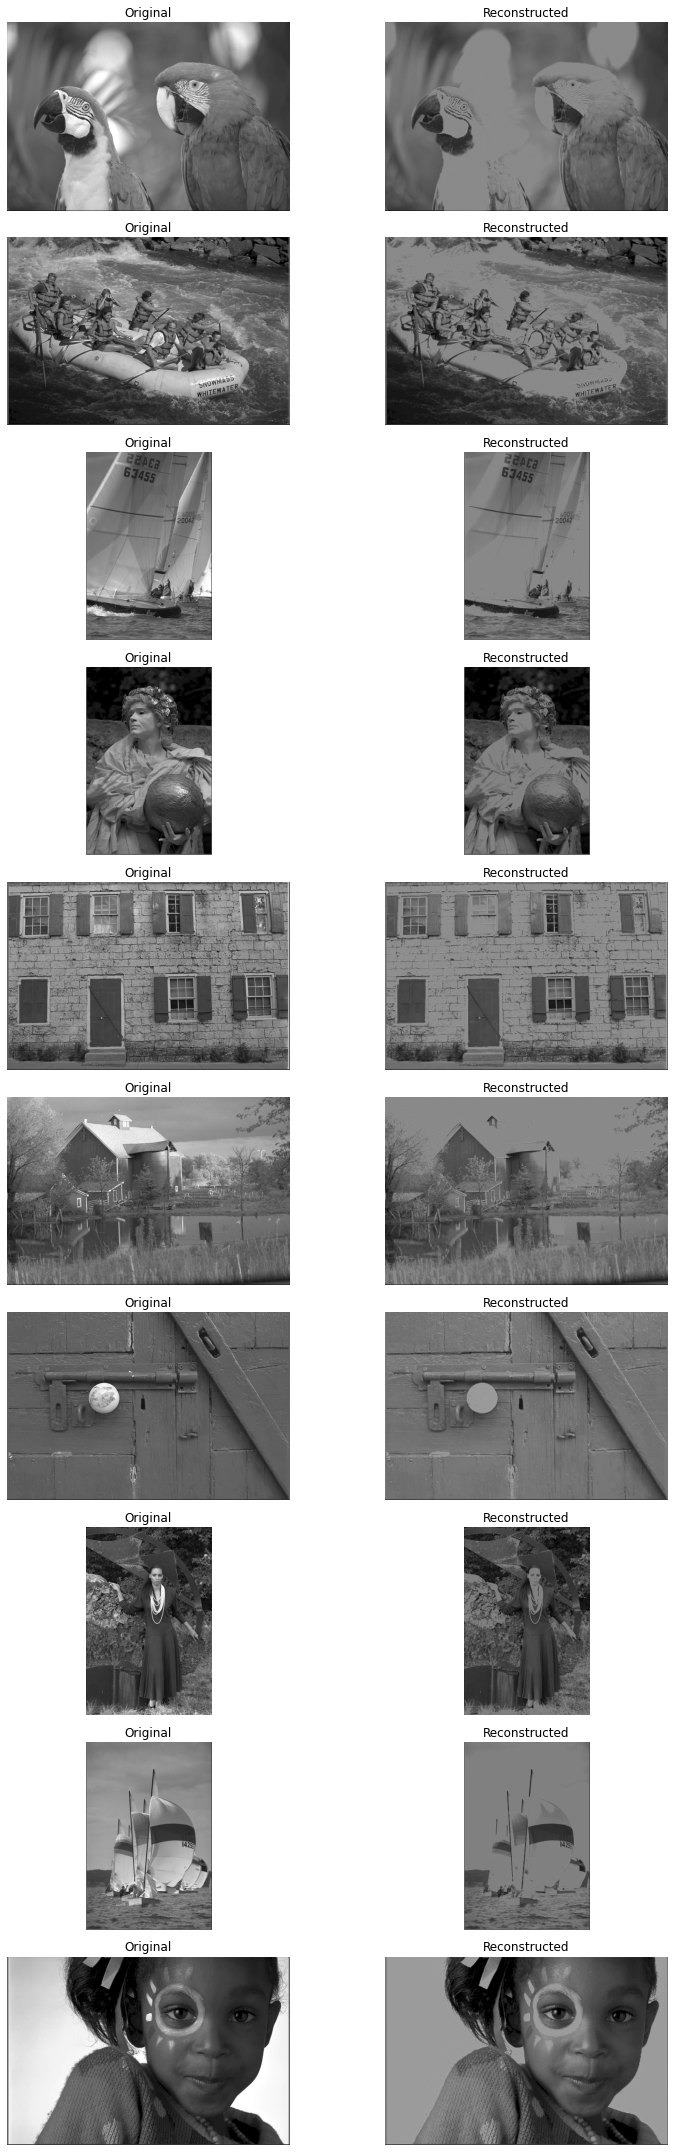

In [51]:
original_folder = "kodak/"
reconstructed_folder = "output/reconstructed_kodak/"

plot_comparison(original_folder, reconstructed_folder, num_images=10)